In [ ]:
!pip install gpytorch
!pip install botorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.3/530.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: linear-operator
    Found existing installation: linear-operator 0.5.0
    Uninstalling linear-operator-0.5.0:
      Successfully uninstalled linear-operator-0.5.0
  Attempting uninstall: gpytorch
    Found existing installation: gpytorch 1.11
    Uninstalling gpytorch-1.11:
      Successfully uninstalled gpytorch-1.11


In [ ]:
import os

import torch
from torch.quasirandom import SobolEngine

from botorch.optim import optimize_acqf
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.model import ModelList

from botorch.test_functions import Branin
from botorch.test_functions import Hartmann
from botorch.test_functions import Cosine8

In [ ]:
tkwargs = {
    "device": torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
    "dtype": torch.double,
}

In [ ]:
beta_mean = 1.0
beta_constraint = 3.0
penalty_weight = 10
BO_iter = 50
num_restarts = 10
raw_samples = 1024
maxiter = 500
GP_iter = 200
learning_rate = 0.1
n_init = 10

In [ ]:
#objective info
dim_list= [6]
name_list= ["Hartmann"]
objective_list = [-3.32237]
plot_bounds = [[-4, 0]]
negate_list = [-1.0]

In [ ]:
#Hartmann
hartmann = Hartmann(dim = 6, negate = True).to(**tkwargs)

def objective1(x):
  return hartmann(x)

In [ ]:
objective = [objective1]

In [ ]:
def compute_grad(x, objective):
  num_points, dimensions = x.shape
  epsilon = 0.01
  grad = torch.zeros(num_points, dimensions)
  for i in range(dimensions):
    x_upper = x.clone()
    x_upper[:, i] += epsilon
    x_lower = x.clone()
    x_lower[:, i] -= epsilon
    grad[:, i] = (objective(x_upper) - objective(x_lower)) / (2 * epsilon)
  return grad

In [ ]:
import gpytorch
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from botorch.models import ModelListGP
from botorch.models.higher_order_gp import FlattenedStandardize
from botorch.models.transforms import Normalize, Standardize
from botorch.models import HigherOrderGP, SingleTaskGP
from gpytorch.constraints import Interval
from botorch.optim.fit import fit_gpytorch_mll_torch
from botorch import fit_gpytorch_model

def train_single_model(X, Y, nu=1.5, noiseless_obs=True):

  if Y.ndim == 1:
      Y = Y.unsqueeze(-1)

  standardize = Standardize(m=Y.shape[-1], batch_shape=Y.shape[:-2])
  outcome_transform = standardize

  covar_module = ScaleKernel(MaternKernel(nu=nu, ard_num_dims=X.shape[-1]))

  if noiseless_obs:
      _, aug_batch_shape = SingleTaskGP.get_batch_dimensions(
          train_X=X,
          train_Y=Y,
      )
      likelihood = GaussianLikelihood(
          batch_shape=aug_batch_shape,
          noise_constraint=Interval(lower_bound=1e-4, upper_bound=1e-3),
      )
  else:
      likelihood = None
  model = SingleTaskGP(
      train_X=X,
      train_Y=Y,
      covar_module=covar_module,
      likelihood=likelihood,
      outcome_transform=outcome_transform,
  )

  model.outcome_transform.eval()
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  fit_gpytorch_model(mll)
  model.eval()
  return model

def train_model(X, Y, nu=2.5, noiseless_obs=True):
  model_list = []
  noutput = Y.shape[1]
  for i in range(noutput):
    model_i = train_single_model(X, Y[:,i], nu=nu, noiseless_obs=noiseless_obs)
    model_list += [model_i]
  return model_list

def get_posterior_stats(model, point):
  """Get the mean and standard deviation of the model's posterior at a given point."""
  model.eval()
  with torch.enable_grad():
    posterior = model.posterior(point)
    mean = posterior.mean
    std_dev = posterior.variance.sqrt()
  return mean, std_dev

In [ ]:
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.utils import t_batch_mode_transform
from torch import Tensor

class ConstrainedUCB(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: ModelList,
        beta_mean: float,
        beta_constraint: float,
        penalty_weight: int,
    ) -> None:
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.model_list_new = model_list_new
        self.beta_mean = beta_mean
        self.beta_constraint = beta_constraint
        self.penalty_weight = penalty_weight

    @t_batch_mode_transform(expected_q=1)
    def forward(self, x: Tensor) -> Tensor:
        means, std_devs = get_posterior_stats(self.model_list_new, x) #b x q x d (q=1)
        means = means.squeeze() #b x d (removes q)
        std_devs = std_devs.squeeze() #b x d
        UCB = means[:, 0] + self.beta_mean * std_devs[:, 0] # b
        constraint_violation = torch.abs(means[:, 1:]) - self.beta_constraint * std_devs[:, 1:] #b x (d - 1) -> first dimension mean removed
        constraint_violation = constraint_violation.unsqueeze(-1) #b x (d-1) x 1
        zero = torch.zeros(constraint_violation.shape) #b x (d-1) x 1
        constraint_penalty = torch.sum(torch.max(constraint_violation, zero) ** 2, dim = 1).squeeze(-1) #b
        result = UCB - self.penalty_weight * constraint_penalty # b
        return result

In [ ]:
#create 4D torch tensor to store Y values (#trials to avg x #test problems x #BO methods x #BO iterations)
num_avg_trials = 1
BO_methods_list = ["EI", "UCB", "KKT"]
num_test_problems = len(dim_list)
num_BO_methods = len(BO_methods_list)

Y_all = torch.zeros((num_avg_trials, num_test_problems, num_BO_methods, BO_iter + n_init))

In [ ]:
def optimize_AF(acq_func, bounds, q = 1, num_restarts = num_restarts, raw_samples = raw_samples, maxiter = maxiter):
  candidate, acq_value = optimize_acqf(
            acq_function = acq_func,
            bounds = bounds,
            q = q,  # number of candidates to generate (1 for single-point optimization)
            num_restarts = num_restarts,  # number of starting points for multistart optimization
            raw_samples = raw_samples,  # number of samples for initialization heuristic
            options = {"maxiter": maxiter},
            sequential = True,  # use sequential optimization
  )
  return candidate, acq_value

In [ ]:
def update_vanilla(X, Y, candidate, name):
  X = torch.vstack((X, candidate))
  Y_mean_new = objective[i](candidate)
  Y = torch.vstack((Y, Y_mean_new))
  print(f"{name}, Best value: {negate_list[i] * Y.max().item()}, X: {candidate}, Y: {negate_list[i] * Y_mean_new.item()}")
  return X, Y

In [ ]:
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition import ExpectedImprovement
import matplotlib.pyplot as plt
import numpy as np
import botorch.settings
suppress_botorch_warnings = True

for a in range(num_avg_trials):
  for i, dim in enumerate(dim_list):
    bounds = torch.cat((torch.zeros(1, dim), torch.ones(1, dim))).to(**tkwargs)

    X = SobolEngine(dimension=dim, scramble=True, seed=0).draw(n_init).to(**tkwargs)
    Y = objective[i](X).unsqueeze(-1)
    X_UCB = X.clone()
    Y_UCB = Y.clone()
    Y_grad = compute_grad(X, objective[i])
    X_KKT = X.clone()
    Y_KKT = torch.hstack((Y.clone(), Y_grad))

    for j in range(BO_iter):
      #print general info
      print(f"\n{name_list[i]}, Trial: {a + 1}, Iteration: {j + 1 + n_init}")

      #expected improvement
      model_list = train_model(X, Y, nu = 2.5)
      #model_list_new = ModelList(*model_list)
      acq_func = ExpectedImprovement(model_list[0], best_f = Y.max())
      candidate, acq_value = optimize_AF(acq_func, bounds)
      X, Y = update_vanilla(X, Y, candidate, "EI")
      print("EI Y grad query", compute_grad(candidate, objective[i]))

      #store EI values
      if len(Y)==BO_iter + n_init:
        Y_all[a, i, 0] = Y.reshape(BO_iter + n_init)

      #upper confidence bound
      model_list = train_model(X_UCB, Y_UCB, nu = 2.5)
      acq_func = UpperConfidenceBound(model_list[0], beta_mean)
      candidate, acq_value = optimize_AF(acq_func, bounds)
      X_UCB, Y_UCB = update_vanilla(X_UCB, Y_UCB, candidate, "UCB")
      print("UCB Y grad query", compute_grad(candidate, objective[i]))

      if len(Y_UCB) == BO_iter + n_init:
        Y_all[a, i, 1] = Y_UCB.reshape(BO_iter + n_init)

      #KKT
      model_list = train_model(X_KKT, Y_KKT, nu = 2.5)
      model_list_new = ModelList(*model_list)
      acq_func = ConstrainedUCB(model_list_new, beta_mean, beta_constraint, penalty_weight)
      candidate, acq_value = optimize_AF(acq_func, bounds)

      Y_mean_new = objective[i](candidate)
      Y_grad_new = compute_grad(candidate, objective[i]).squeeze()
      Y_new = torch.hstack((Y_mean_new, Y_grad_new))
      X_KKT = torch.vstack((X_KKT, candidate))
      Y_KKT = torch.vstack((Y_KKT, Y_new))
      Y_grad_GP = get_posterior_stats(model_list_new, candidate)[0][0, 1:]
      print("KKT, Best value: ", negate_list[i] * Y_KKT[:, 0].max().item(), ", X: ", candidate, "AF: ", acq_value, ", Y: ", negate_list[i] * Y_mean_new.item(), ", Y grad GP: ", negate_list[i] * Y_grad_GP, ", Y grad query: ", negate_list[i] * Y_grad_new)

      if len(Y_KKT) == BO_iter + n_init:
        Y_all[a, i, 2] = Y_KKT[:, 0].reshape(BO_iter + n_init)


Hartmann, Trial: 1, Iteration: 11
EI, Best value: -1.16420343697261, X: tensor([[0.5158, 0.9524, 0.9794, 0.4623, 0.8550, 0.5155]], dtype=torch.float64), Y: -0.08694531752572719
EI Y grad query tensor([[-0.3302, -0.1018, -0.0138,  0.1875, -0.0214, -1.1445]])
UCB, Best value: -1.16420343697261, X: tensor([[0.3774, 0.9694, 0.9955, 0.7503, 0.8793, 0.2805]], dtype=torch.float64), Y: -0.9032024425650242
UCB Y grad query tensor([[ 0.8356, -1.2510, -0.0142, -3.1770, -0.1395, -6.1244]])
KKT, Best value:  -1.16420343697261 , X:  tensor([[0.2815, 0.9693, 0.9955, 0.7082, 0.8793, 0.3453]], dtype=torch.float64) AF:  tensor(1.3604, dtype=torch.float64) , Y:  -0.48972629176476584 , Y grad GP:  tensor([-3.4760, -0.5461,  0.0419,  0.0398, -0.0765,  2.6808],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-2.0441,  0.6794,  0.0136,  1.3114,  0.0762,  4.2047])

Hartmann, Trial: 1, Iteration: 12
EI, Best value: -1.16420343697261, X: tensor([[0.4523, 0.9967, 0.9700, 0.8377, 0.8

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  -1.16420343697261 , X:  tensor([[0.1273, 0.4146, 0.8628, 0.3265, 0.6655, 0.5113]], dtype=torch.float64) AF:  tensor(1.2612, dtype=torch.float64) , Y:  -0.24519392695409345 , Y grad GP:  tensor([-4.3108e+00, -2.4768e-03,  1.1991e-01,  6.2402e-01,  1.8958e-01,
         1.1899e+00], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.1238,  0.3785,  1.3689,  0.3227,  1.5496, -0.4514])

Hartmann, Trial: 1, Iteration: 19
EI, Best value: -1.9501130238135533, X: tensor([[0.3175, 0.9164, 0.5553, 0.8093, 0.7541, 0.1294]], dtype=torch.float64), Y: -1.3646164380368615
EI Y grad query tensor([[ 4.0227, -0.7440,  0.0434, -6.4134, -0.1761, -3.4588]])
UCB, Best value: -2.952456908704659, X: tensor([[0.3677, 0.8814, 0.0000, 0.6163, 0.0000, 0.0317]], dtype=torch.float64), Y: -2.952456908704659
UCB Y grad query tensor([[ 3.7079,  0.0624,  0.2590, -2.4838,  0.0746,  0.5375]])
KKT, Best value:  -1.9186857970329874 , X:  tensor([[0.2677, 0.9559, 0.8882, 0.5881, 0.0063

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.5416, 0.5303, 1.0000, 0.6655, 0.0000, 0.0000]], dtype=torch.float64) AF:  tensor(1.4788, dtype=torch.float64) , Y:  -0.7762543502491672 , Y grad GP:  tensor([ 5.2885, -3.2994, -0.0178,  2.5392, -0.2382, -0.9972],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 3.6048, -4.3683,  0.0122,  1.4194, -0.0269, -0.8363])

Hartmann, Trial: 1, Iteration: 40
EI, Best value: -3.1990565036055827, X: tensor([[0.4039, 0.8794, 1.0000, 0.5755, 0.1508, 0.0397]], dtype=torch.float64), Y: -3.1990565036055827
EI Y grad query tensor([[ 0.0885,  0.1580, -0.0471, -0.0920, -0.0129, -0.1171]])
UCB, Best value: -3.1941754097384454, X: tensor([[0.4055, 0.8808, 1.0000, 0.5775, 0.0000, 0.0403]], dtype=torch.float64), Y: -3.193776098828501
UCB Y grad query tensor([[-0.0885,  0.0983, -0.0428, -0.2091,  0.0780, -0.1874]])
KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.4417, 0.8116, 0.9223, 0.9201, 0.1337, 0.0377]], dtype=torch

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.2690, 1.0000, 0.8866, 0.9763, 0.0000, 0.0000]], dtype=torch.float64) AF:  tensor(0.9401, dtype=torch.float64) , Y:  -0.4076508124928947 , Y grad GP:  tensor([-3.9440,  1.9561,  0.0289,  4.2576, -0.0205, -0.8046],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.8782e+00,  7.6393e-01,  6.9923e-04,  3.2778e+00, -9.0073e-03,
        -4.3446e-01])

Hartmann, Trial: 1, Iteration: 45
EI, Best value: -3.1994414066190333, X: tensor([[0.0276, 0.2384, 0.8188, 0.0190, 0.7455, 0.9848]], dtype=torch.float64), Y: -0.12256507998542876
EI Y grad query tensor([[ 0.1788,  0.0674, -0.7011,  0.0733, -0.5067, -0.5510]])
UCB, Best value: -3.1941754097384454, X: tensor([[0.4044, 0.8897, 1.0000, 0.5768, 0.0000, 0.0380]], dtype=torch.float64), Y: -3.192985925550763
UCB Y grad query tensor([[ 0.0280, -0.3559, -0.0426, -0.1647,  0.0775,  0.0151]])


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.7466, 0.2694, 0.0000, 0.0259, 0.0000, 0.7071]], dtype=torch.float64) AF:  tensor(0.7581, dtype=torch.float64) , Y:  -0.10722823599226146 , Y grad GP:  tensor([ 0.8856,  0.2012, -0.0561, -1.0665, -0.4454, -0.3983],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.3296,  0.0933, -0.1290, -0.5622, -1.1107,  0.0722])

Hartmann, Trial: 1, Iteration: 46
EI, Best value: -3.1994414066190333, X: tensor([[0.5495, 0.9519, 0.6900, 0.4025, 0.5081, 0.0382]], dtype=torch.float64), Y: -1.5816265673494898
EI Y grad query tensor([[-7.7702, -1.7657,  0.0208,  5.4047, -0.1492,  0.0411]])
UCB, Best value: -3.1941754097384454, X: tensor([[0.4068, 0.8811, 1.0000, 0.5784, 0.0000, 0.0354]], dtype=torch.float64), Y: -3.1932372199054324
UCB Y grad query tensor([[-0.2270,  0.0805, -0.0426, -0.2691,  0.0776,  0.2458]])


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.5811, 0.8272, 0.2683, 0.2802, 0.2639, 0.0000]], dtype=torch.float64) AF:  tensor(1.1595, dtype=torch.float64) , Y:  -0.7553360935247098 , Y grad GP:  tensor([ 4.8222, -0.9387, -0.1059, -3.5678,  0.1293, -1.1849],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 4.4807, -0.6053, -0.0507, -4.3730,  0.0066, -0.9167])

Hartmann, Trial: 1, Iteration: 47
EI, Best value: -3.1994414066190333, X: tensor([[0.1249, 0.9778, 0.2059, 0.9212, 0.6451, 0.9388]], dtype=torch.float64), Y: -0.0006929277835953213
EI Y grad query tensor([[ 0.0003, -0.0037,  0.0044, -0.0065, -0.0038, -0.0035]])
UCB, Best value: -3.1941754097384454, X: tensor([[0.4052, 0.8821, 1.0000, 0.5733, 0.0000, 0.0416]], dtype=torch.float64), Y: -3.1938836035273823
UCB Y grad query tensor([[-0.0516,  0.0310, -0.0428,  0.0611,  0.0783, -0.3020]])
KKT, Best value:  -3.0171366451951047 , X:  tensor([[1.0000, 0.2293, 0.0000, 0.2927, 1.0000, 0.6866]], dtype=t

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.6331, 1.0000, 1.0000, 0.9138, 0.0000, 0.0000]], dtype=torch.float64) AF:  tensor(0.9375, dtype=torch.float64) , Y:  -0.36484706023264746 , Y grad GP:  tensor([ 5.1704e+00,  1.8396e+00,  1.3471e-03,  3.9759e+00, -2.5159e-02,
        -7.7249e-01], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 2.8313,  0.6837,  0.0047,  2.4765, -0.0080, -0.3888])

Hartmann, Trial: 1, Iteration: 49
EI, Best value: -3.1994414066190333, X: tensor([[0.9214, 0.0441, 0.3928, 0.0320, 0.2572, 0.0290]], dtype=torch.float64), Y: -0.013836130597619012
EI Y grad query tensor([[-0.0577,  0.0099, -0.0016,  0.0706,  0.0223,  0.1408]])
UCB, Best value: -3.1941754097384454, X: tensor([[0.4058, 0.8801, 1.0000, 0.5761, 0.0000, 0.0405]], dtype=torch.float64), Y: -3.1938641306404785
UCB Y grad query tensor([[-0.1172,  0.1318, -0.0428, -0.1206,  0.0781, -0.2046]])


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.3838, 0.4451, 1.0000, 0.4586, 0.0000, 0.0000]], dtype=torch.float64) AF:  tensor(1.0026, dtype=torch.float64) , Y:  -0.5914824773665383 , Y grad GP:  tensor([-0.7500, -2.6233, -0.0297, -2.4399, -0.0465, -1.2895],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.4124, -4.0999,  0.0196, -1.3409, -0.0599, -0.6745])

Hartmann, Trial: 1, Iteration: 50
EI, Best value: -3.1994414066190333, X: tensor([[0.4995, 0.5682, 0.3646, 0.8485, 0.2348, 0.0089]], dtype=torch.float64), Y: -0.5732963256079885
EI Y grad query tensor([[-1.8434,  2.8696,  0.0308, -3.1518, -0.0099,  0.4863]])
UCB, Best value: -3.1941754097384454, X: tensor([[0.4069, 0.8822, 1.0000, 0.5764, 0.0000, 0.0337]], dtype=torch.float64), Y: -3.193139171350869
UCB Y grad query tensor([[-0.2415,  0.0279, -0.0426, -0.1374,  0.0775,  0.3963]])
KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.0000, 0.0000, 1.0000, 0.4135, 0.0000, 0.6192]], dtype=torch

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.0770, 0.6967, 0.7099, 0.5185, 0.3001, 0.0000]], dtype=torch.float64) AF:  tensor(0.7944, dtype=torch.float64) , Y:  -0.38714030486704143 , Y grad GP:  tensor([-4.7569, -2.7904,  0.0177, -0.5711,  0.0425, -0.5205],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-4.1349e+00, -1.0340e+00,  3.3417e-02, -3.3506e-01,  3.9550e-03,
        -5.7672e-01])

Hartmann, Trial: 1, Iteration: 54
EI, Best value: -3.1994414066190333, X: tensor([[0.4127, 0.7908, 0.4718, 0.4858, 0.6720, 0.0065]], dtype=torch.float64), Y: -2.622849190328926
EI Y grad query tensor([[-0.7324,  3.8299,  0.1151,  4.6110, -0.3092,  2.3628]])
UCB, Best value: -3.1941754097384454, X: tensor([[0.4066, 0.8839, 1.0000, 0.5780, 0.0000, 0.0351]], dtype=torch.float64), Y: -3.1933324105425327
UCB Y grad query tensor([[-0.2117, -0.0587, -0.0426, -0.2386,  0.0774,  0.2754]])
KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.9824, 0.4059, 1.0000, 0.00

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.4939, 0.6777, 1.0000, 0.7764, 0.1751, 0.2843]], dtype=torch.float64) AF:  tensor(1.0021, dtype=torch.float64) , Y:  -0.5774140643517794 , Y grad GP:  tensor([ 2.7808, -2.7000,  0.0277,  3.1463, -0.2642,  3.7892],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 1.7335, -1.8227,  0.0321,  2.3872, -0.0351,  3.8430])

Hartmann, Trial: 1, Iteration: 56
EI, Best value: -3.1994414066190333, X: tensor([[0.0434, 0.0511, 0.7251, 0.9802, 0.0363, 0.9993]], dtype=torch.float64), Y: -0.252379650739365
EI Y grad query tensor([[ 0.0103,  1.8036,  0.8778, -0.0713,  0.2783, -0.0247]])
UCB, Best value: -3.1941754097384454, X: tensor([[0.4056, 0.8821, 1.0000, 0.5755, 0.0000, 0.0413]], dtype=torch.float64), Y: -3.193905304145922
UCB Y grad query tensor([[-0.0967,  0.0300, -0.0428, -0.0783,  0.0782, -0.2805]])
KKT, Best value:  -3.0171366451951047 , X:  tensor([[0.2528, 0.6707, 0.6611, 0.2612, 0.4948, 0.0000]], dtype=torch.

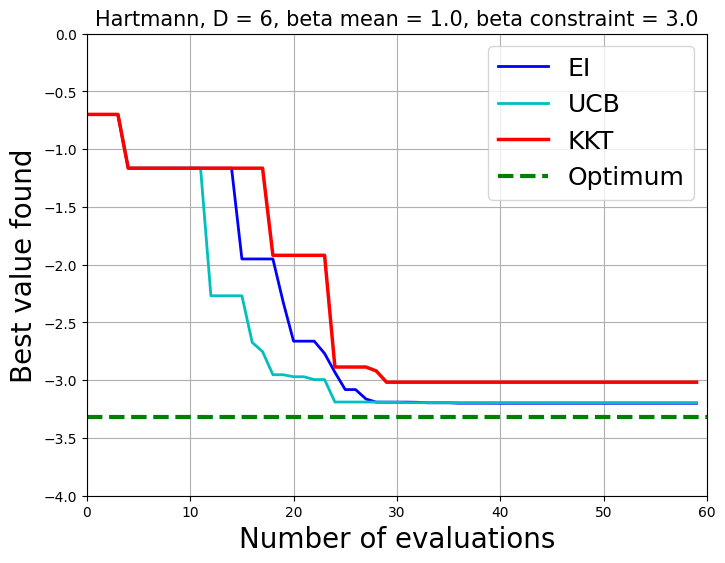

In [ ]:
%matplotlib inline
#average values from the different trials first
Y_all_avg = Y_all.mean(dim = 0)

for i in range(num_test_problems):
  Y_EI_np = negate_list[i] * Y_all_avg[i, 0].cpu().numpy()
  Y_UCB_np = negate_list[i] * Y_all_avg[i, 1].cpu().numpy()
  Y_KKT_np = negate_list[i] * Y_all_avg[i, 2].cpu().numpy()

  fig, ax = plt.subplots(figsize=(8, 6))
  if negate_list[i] < 0:
    ax.plot(np.minimum.accumulate(Y_EI_np), color="b", lw = 2, label="EI")
    ax.plot(np.minimum.accumulate(Y_UCB_np), color="c", lw = 2, label="UCB")
    ax.plot(np.minimum.accumulate(Y_KKT_np), color="r", lw = 2.5, label="KKT")
  elif negate_list[i] > 0:
    ax.plot(np.maximum.accumulate(Y_EI_np), color="b", lw = 2, label="EI")
    ax.plot(np.maximum.accumulate(Y_UCB_np), color="c", lw = 2, label="UCB")
    ax.plot(np.maximum.accumulate(Y_KKT_np), color="r", lw = 2.5, label="KKT")
  ax.plot([0, len(Y_EI_np)], [objective_list[i], objective_list[i]], "--", c="g", lw=3, label="Optimum")

  ax.grid(True)
  ax.set_title(f"{name_list[i]}, D = {dim_list[i]}, beta mean = {beta_mean}, beta constraint = {beta_constraint}", fontsize=15)
  ax.set_xlabel("Number of evaluations", fontsize=20)
  ax.set_xlim([0, len(Y_EI_np)])
  ax.set_ylabel("Best value found", fontsize=20)
  ax.set_ylim([plot_bounds[i][0], plot_bounds[i][1]])
  ax.legend(fontsize=18)
  plt.show()